#### 케라스에 포함된 IMDB 데이터는 미리 토큰화가 되어있기 때문에 원본 텍스트 데이터 부터 시작!!

### 원본 텍스트 데이터 내려받기
> http://mng.bz/0tIo 에서 원본 데이터셋을 내려받고 압축을 해제한다.

### IMDB 원본 데이터 전처리하기

In [9]:
import os

imbd_dir = './datasets/aclImdb'
train_dir = os.path.join(imbd_dir, 'test')

labels = []

texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
                
### 약간 책에서 나온거와는 틀리게 train을 하면 오류가 나길래 test로 바꿨더니 됬다. 된건가?ㅋㅋㅋ

### 데이터 토큰화
> 텍스트를 벡터로 만들고 훈련 세트와 검증 세트로 나눈다. 사전 훈련된 단어 임베딩은 훈련 데이터가 부족한 문제에 특히 유용하다. 그래서 다음과 같이 훈련 데이터를 처음 200개의 샘플로 제한한다. 이 모델은 200개의 샘플을 학습한 후 영화 리뷰를 분류할 것이다.

### IMDB 원본 데이터의 텍스트를 토큰화하기

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # 100개 단어 이후는 버린다.
trainig_samples = 200 # 훈련 샘플은 200개이다.
validation_samples = 10000 # 검증 샘플은 1만개이다.
max_words = 10000 # 데이터셋에서 가장 빈도 높은 1만개의 단어만 사용한다.

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequence = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("%s개의 고유한 토큰을 찾았습니다." % len(word_index))

72633개의 고유한 토큰을 찾았습니다.


In [18]:
data = pad_sequences(sequence, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indice = np.arange(data.shape[0]) # 데이터를 훈련세트와 검증세트로 분할 한다. 샘플이 순서대로 있기 떄문에 먼저 데이터를 섞는다.
np.random.shuffle(indice)
data = data[indice]
labels = labels[indice]

x_train = data[:trainig_samples]
y_train = labels[:trainig_samples]
x_val = data[trainig_samples: trainig_samples+validation_samples]
y_val = labels[trainig_samples: trainig_samples+validation_samples]

데이터 텐서의 크기: (17243, 100)
레이블 텐서의 크기: (17243,)


### GloVe 단어 임베딩 내려 받기
> https://nlp.stanford.edu/projects/glove 에서 영문 위키피디아를 사용하여 사전에 계산된 임베딩을 내려 받는다. 파일의 이름은 glove.6B.zip이다. 40만개의 단어에 대한 100차원의 임베딩 벡터를 포함하고 있다.

### 임베딩 전처리
> 압축해제한 파일을 파싱하여 단어와 이에 상응하는 벡터 표현을 매핑하는 인덱스를 만든다.

### GloVe 단어 임베딩 파일 파싱하기

In [19]:
glove_dir = './datasets/'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embedding_index))

400000개의 단어 벡터를 찾았습니다.


> 그 다음 Embedding 층에 주입할 수 있도록 임베딩 행렬을 만든다. 이 행렬의 크기는 (max_words, embedding_dim)이어야 한다.
 이 행렬의 i번째 원소는 토큰화로 만든 단어 인덱스의 i번째 단어에 상응하는 embedding_index 차원 벡터이다. 인덱스 0은 어떤 단어나 토큰도 아닌 경우이다.
 
 ### GloVe 단어 임베딩 행렬 준비하기

In [20]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # 임베딩 인덱스에 없는 단어는 모두 0이 된다.

### 모델 정의하기

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 모델에 GloVe 임베딩 로드하기
> Embedding 층은 하나의 가중치 행렬을 가진다. 이 행렬은 2D 부동 소수 행렬이고 각 i번째 원소는 i번째 인덱스에 상응하는 단어 벡터이다. 모델의 첫번째 층인 emvedding 층에 행렬을 로드한다.

### 사전 훈련된 임베딩을 Embedding 층에 로드하기

In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

> 추가적으로 Embedding 층을 동결한다(trainable속성을 false로). 사전 훈련된 컨브넷 특성을 사용할 때와 같은 이유인데, 훈련하는 동안 사전 훈련된 부분이 업데이트 되면 안되기 때문이다.

### 모델 훈련과 평가

In [23]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 124ms/step - loss: 1.6106 - acc: 0.7193 - val_loss: 0.6800 - val_acc: 0.7245
Epoch 2/10
7/7 [==============================] - 0s 77ms/step - loss: 0.4554 - acc: 0.7682 - val_loss: 0.6002 - val_acc: 0.7245
Epoch 3/10
7/7 [==============================] - 1s 86ms/step - loss: 0.3589 - acc: 0.7980 - val_loss: 0.7425 - val_acc: 0.7245
Epoch 4/10
7/7 [==============================] - 0s 82ms/step - loss: 0.3282 - acc: 0.7536 - val_loss: 1.1500 - val_acc: 0.7245
Epoch 5/10
7/7 [==============================] - 1s 83ms/step - loss: 0.3368 - acc: 0.8265 - val_loss: 1.0020 - val_acc: 0.7245
Epoch 6/10
7/7 [==============================] - 0s 78ms/step - loss: 0.1987 - acc: 0.8439 - val_loss: 0.6305 - val_acc: 0.7241
Epoch 7/10
7/7 [==============================] - 1s 92ms/step - loss: 0.1976 - acc: 0.8995 - val_loss: 0.9817 - val_acc: 0.7245
Epoch 8/10
7/7 [==============================] - 0s 78ms/step - loss: 0.1653 - acc: 0.8662 - va

### 결과 그래프 그리기

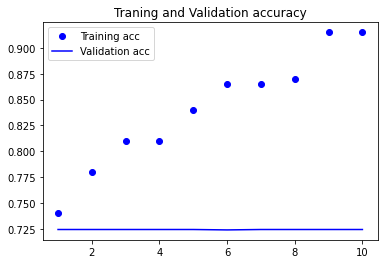

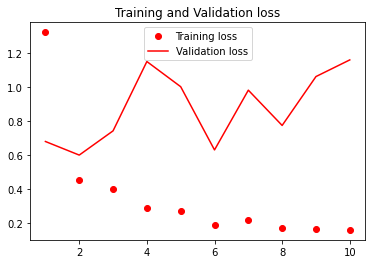

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Traning and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

약간 선넘었다고 생각한다.... val_acc가 ㅋㅋㅋㅋㅋㅋㅋㅋ저게 뭐냐?ㅋㅋㅋㅋㅋㅋㅋ 훈련 샘플이 적어서 그런걸까....정말 눈물이난다.

#### 해당 작업에 특화된 임데잉을 사용해 보자!!

### 사전 훈련된 단어 임베딩말고 같은 모델 훈련하기!!!

In [26]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))


Epoch 1/10
7/7 [==============================] - 1s 118ms/step - loss: 0.6646 - acc: 0.6142 - val_loss: 0.6110 - val_acc: 0.7245
Epoch 2/10
7/7 [==============================] - 1s 98ms/step - loss: 0.3921 - acc: 0.8656 - val_loss: 0.5985 - val_acc: 0.7245
Epoch 3/10
7/7 [==============================] - 1s 93ms/step - loss: 0.2275 - acc: 0.9835 - val_loss: 0.5982 - val_acc: 0.7246
Epoch 4/10
7/7 [==============================] - 1s 111ms/step - loss: 0.1103 - acc: 0.9881 - val_loss: 0.6241 - val_acc: 0.7245
Epoch 5/10
7/7 [==============================] - 1s 107ms/step - loss: 0.0503 - acc: 1.0000 - val_loss: 0.6351 - val_acc: 0.7246
Epoch 6/10
7/7 [==============================] - 1s 101ms/step - loss: 0.0275 - acc: 1.0000 - val_loss: 0.7175 - val_acc: 0.7245
Epoch 7/10
7/7 [==============================] - 1s 119ms/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.7246
Epoch 8/10
7/7 [==============================] - 1s 85ms/step - loss: 0.0079 - acc: 1.0000 

#### 그게 그거인것같은데....

적은 훈련샘플이라서 그렇다고 치자!!